In [ ]:
# ======================
# 🔧 BLOK 1 - SETUP & LIBRARY
# ======================
!pip install -q tensorflow scikeras

from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inspect
import warnings
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

inspect.signature(KerasClassifier.__init__)
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [ ]:
# ======================
# 📥 BLOK 2 - LOAD DATA
# ======================
df = pd.read_csv('[LINK_DRIVE]')
df['date'] = pd.to_datetime(df['date'])

# Label encoding
le = LabelEncoder()
df['label'] = le.fit_transform(df['weather'])
X = df[['precipitation', 'temp_max', 'temp_min', 'wind']]
y = df['label']

In [ ]:
# ======================
# 📊 BLOK 3 - SCALING & SPLITTING
# ======================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_cat = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_cat, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Hitung class weight untuk handling imbalance
y_train_labels = np.argmax(y_train, axis=1)
class_weights_dict = dict(enumerate(class_weight.compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)))


In [ ]:
# ======================
# 🤖 BLOK 4 - Tunning CNN, LSTM, BiLSTM
# ======================
from itertools import product
import random

def build_and_train(model_type, units, dropout_rate, learning_rate, batch_size):
    model = Sequential()
    if model_type == 'CNN':
        model.add(Conv1D(units, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
        model.add(MaxPooling1D(pool_size=1))
        model.add(Flatten())
    elif model_type == 'LSTM':
        model.add(LSTM(units, input_shape=(X_train.shape[1], 1)))
    elif model_type == 'BiLSTM':
        model.add(Bidirectional(LSTM(units), input_shape=(X_train.shape[1], 1)))

    model.add(Dropout(dropout_rate))
    model.add(Dense(units, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=0, class_weight=class_weights_dict)
    score = model.evaluate(X_test, y_test, verbose=0)
    return model, score[1]  # return model & accuracy

# Hyperparameter space
param_grid = {
    'units': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [16, 32]
}

models = {}
best_params = {}

for model_type in ['CNN', 'LSTM', 'BiLSTM']:
    print(f"\n🔍 Tuning : {model_type}")
    param_combinations = list(product(
        param_grid['units'],
        param_grid['dropout_rate'],
        param_grid['learning_rate'],
        param_grid['batch_size']
    ))

    sampled_combinations = random.sample(param_combinations, 5)  # Ambil 5 kombinasi acak
    best_acc = 0
    best_model = None
    best_combo = None

    for units, dropout, lr, batch in sampled_combinations:
        model, acc = build_and_train(model_type, units, dropout, lr, batch)
        print(f"• Params: units={units}, dropout={dropout}, lr={lr}, batch={batch} → acc={acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_model = model
            best_combo = (units, dropout, lr, batch)







    models[model_type] = best_model
    best_params[model_type] = {
        'units': best_combo[0],
        'dropout_rate': best_combo[1],
        'learning_rate': best_combo[2],
        'batch_size': best_combo[3]
    }
    print(f"✅ Best Params for {model_type}: {best_params[model_type]} | acc={best_acc:.4f}")



🔍 Tuning : CNN
• Params: units=32, dropout=0.4, lr=0.001, batch=16 → acc=0.5290
• Params: units=64, dropout=0.2, lr=0.001, batch=32 → acc=0.5631
• Params: units=128, dropout=0.2, lr=0.0005, batch=16 → acc=0.6382
• Params: units=32, dropout=0.3, lr=0.0005, batch=32 → acc=0.4676
• Params: units=32, dropout=0.4, lr=0.0005, batch=32 → acc=0.4505
✅ Best Params for CNN: {'units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 16} | acc=0.6382

🔍 Tuning : LSTM
• Params: units=128, dropout=0.2, lr=0.0005, batch=32 → acc=0.5597
• Params: units=128, dropout=0.2, lr=0.001, batch=32 → acc=0.5119
• Params: units=128, dropout=0.3, lr=0.001, batch=32 → acc=0.4983
• Params: units=128, dropout=0.4, lr=0.0005, batch=32 → acc=0.4881
• Params: units=32, dropout=0.4, lr=0.001, batch=16 → acc=0.3959
✅ Best Params for LSTM: {'units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32} | acc=0.5597

🔍 Tuning : BiLSTM
• Params: units=64, dropout=0.4, lr=0.0005, batch=32 → ac


--- Evaluasi Model ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

📊 CNN Accuracy: 0.6382
              precision    recall  f1-score   support

     drizzle       0.10      0.27      0.15        11
         fog       0.20      0.40      0.26        20
        rain       0.96      0.68      0.80       129
        snow       0.16      0.60      0.25         5
         sun       0.76      0.66      0.71       128

    accuracy                           0.64       293
   macro avg       0.43      0.52      0.43       293
weighted avg       0.77      0.64      0.69       293



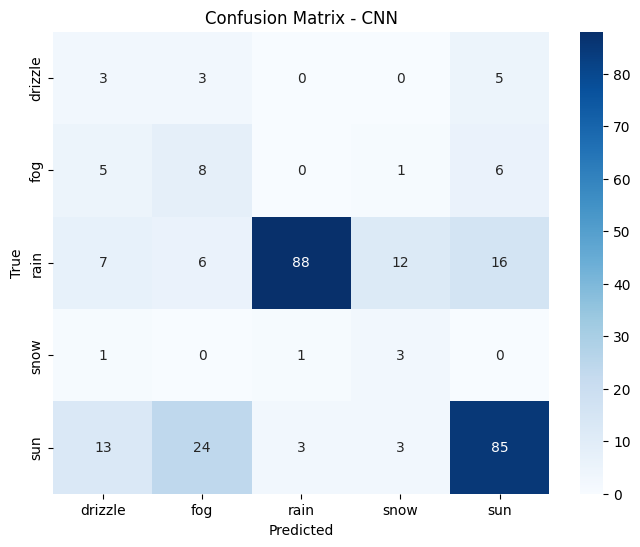

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

📊 LSTM Accuracy: 0.5597
              precision    recall  f1-score   support

     drizzle       0.09      0.18      0.12        11
         fog       0.15      0.45      0.23        20
        rain       0.85      0.60      0.71       129
        snow       0.23      0.60      0.33         5
         sun       0.68      0.56      0.62       128

    accuracy                           0.56       293
   macro avg       0.40      0.48      0.40       293
weighted avg       0.69      0.56      0.61       293



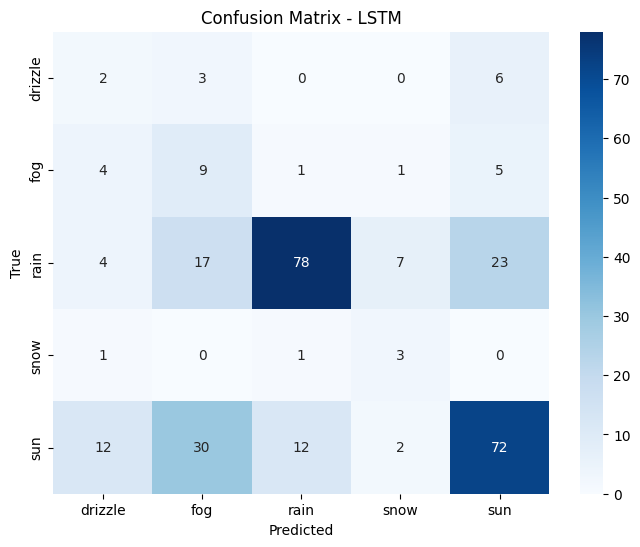

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step

📊 BiLSTM Accuracy: 0.5973
              precision    recall  f1-score   support

     drizzle       0.06      0.09      0.07        11
         fog       0.19      0.50      0.27        20
        rain       0.90      0.67      0.76       129
        snow       0.12      0.60      0.19         5
         sun       0.74      0.59      0.66       128

    accuracy                           0.60       293
   macro avg       0.40      0.49      0.39       293
weighted avg       0.74      0.60      0.65       293



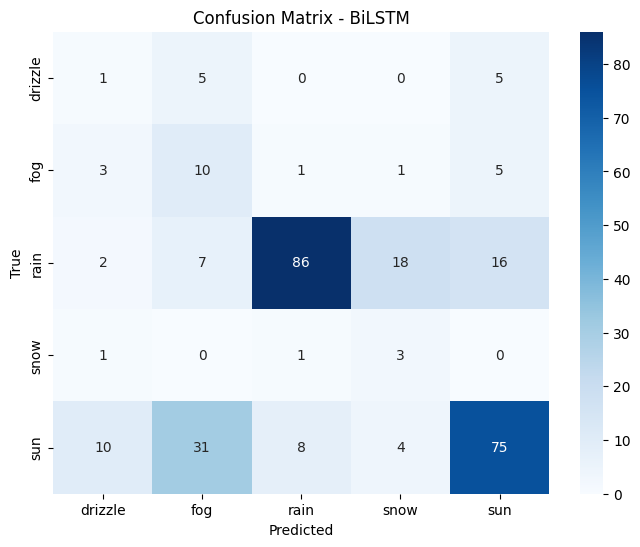

In [ ]:
# ======================
# 🧪 BLOK 5 - EVALUASI MODEL
# ======================
def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    acc = accuracy_score(y_true_labels, y_pred_labels)
    print(f"\n📊 {name} Accuracy: {acc:.4f}")
    print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print("\n--- Evaluasi Model ---")
for model_type, model in models.items():
    evaluate_model(model, model_type)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


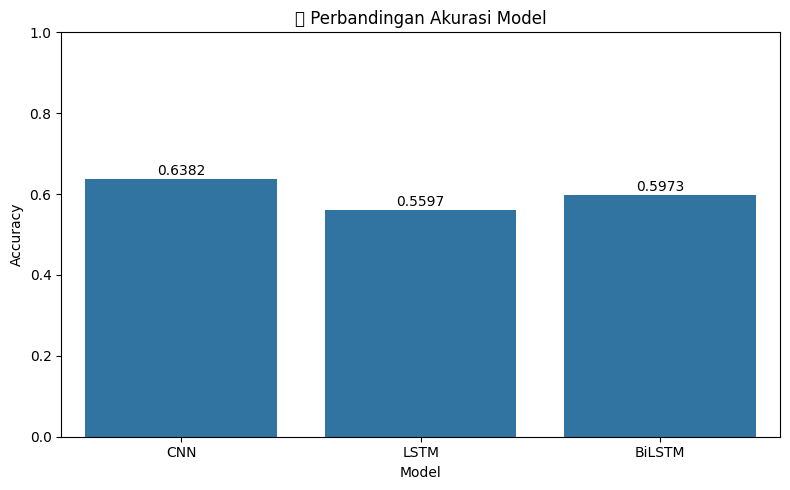

In [ ]:
# ======================
# ✅ BLOK 6 - PERBANDINGAN AKURASI MODEL
# ======================
accuracies = {}

for model_type, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    acc = accuracy_score(y_true_labels, y_pred_labels)
    accuracies[model_type] = acc

# Visualisasi akurasi
plt.figure(figsize=(8, 5))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title("📊 Perbandingan Akurasi Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xlabel("Model")
for i, v in enumerate(accuracies.values()):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
# ======================
# 🌦️ BLOK 7 - PREDIKSI CUACA BARU
# ======================
new_data = pd.DataFrame([[2.0, 13.0, 5.0, 3.2]], columns=X.columns)
new_scaled = scaler.transform(new_data).reshape((1, X.shape[1], 1))
print("\n🌤️ Prediksi Cuaca Baru:")
for model_type, model in models.items():
    pred = model.predict(new_scaled)
    label = le.inverse_transform([np.argmax(pred)])[0]
    print(f"{model_type:<7} predicts: {label}")



🌤️ Prediksi Cuaca Baru:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
CNN     predicts: rain
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LSTM    predicts: rain
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
BiLSTM  predicts: rain
